# Data Science Challenge

In [363]:
# If you'd like to install packages that aren't installed by default, uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere

#import sys
#!{sys.executable} -m pip install <package list>

In [364]:
#!pip install pandas==2.2.3 numpy==1.26.4 scikit-learn==1.6.1 xgboost==2.1.4 matplotlib==3.10.1
#OR
#import sys
#!{sys.executable} -m pip install pandas==2.2.3 numpy==1.26.4 scikit-learn==1.6.1 xgboost==2.1.4 matplotlib==3.10.1

In [365]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import matplotlib

print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Scikit-Learn version:", sklearn.__version__)
print("XGBoost version:", xgb.__version__)
print("Matplotlib version:", matplotlib.__version__)


Pandas version: 2.2.3
NumPy version: 1.26.4
Scikit-Learn version: 1.6.1
XGBoost version: 2.1.4
Matplotlib version: 3.10.1


In [366]:
#Libraries
import pandas as pd
pd.set_option("display.max_columns", 101)

In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

In [368]:
def preprocess(df, is_train=True):
    # Convert date and extract year and month
    if is_train:
        df['date'] = pd.to_datetime(df['date'], format="%d/%m/%y", errors='coerce')
    else:
        df['date'] = pd.to_datetime(df['date'], format="%d-%m-%y", errors='coerce')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    # Fill missing numerical values
    for col in ['lat', 'long', 'pop', 'price']:
        df[col] = df[col].fillna(df[col].median())
    # Fill missing categorical values
    for col in ['brand', 'capacity', 'container', 'city', 'shop']:
        df[col] = df[col].fillna(df[col].mode()[0])
    df.drop(columns=['date'], inplace=True)
    if is_train:
        df = df.dropna(subset=['quantity'])
    return df

## Data Description

Column | Description
:---|:---
`id` | Unique Identifier
`brand` | The brand name of the product
`capacity` | The volume of each container (lt/ml)
`city`| The name of the city for each shop 
`container`| The type (nature) of the container.
`date`| Date of sale
`lat`| The latitude of the shop
`long`| The longitude of the shop
`pop` | Population of the city (assumed constant)
`shop` | the shop id
`price`| The average monthly price of the corresponding container (in US `$$`)
`quantity` | The number of containers sold in a month (target variable)

## Data Wrangling & Visualization

In [369]:
data = pd.read_csv('train.csv', index_col=0)

In [370]:
data.head()

,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
id,,,,,,,,,,,
0.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,glass,500ml,0.96,13280.0
1.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,plastic,1.5lt,2.86,6727.0
2.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,kinder-cola,can,330ml,0.87,9848.0
3.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,glass,500ml,1.00,20050.0
4.0,31/01/12,Athens,37.97945,23.71622,672130.0,shop_1,adult-cola,can,330ml,0.39,25696.0


In [371]:
#Explore columns
data.columns

Index(['date', 'city', 'lat', 'long', 'pop', 'shop', 'brand', 'container',
       'capacity', 'price', 'quantity'],
      dtype='object')

In [372]:
#Description
data.describe()

,lat,long,pop,price,quantity
count,6429.000000,6434.000000,6480.000000,6480.000000,6480.000000
mean,38.301238,23.270246,355141.416667,1.188981,29431.855093
std,1.649771,1.086960,232828.796289,0.814567,17901.328301
min,35.327870,21.734440,134219.000000,0.110000,2953.000000
25%,37.962450,22.417610,141439.750000,0.610000,16441.750000
50%,38.244440,22.930860,257501.500000,0.920000,25184.000000
75%,39.636890,23.716220,665871.000000,1.500000,37866.000000
max,40.643610,25.143410,672130.000000,4.540000,145287.000000


In [373]:
datatest = pd.read_csv('test.csv', index_col=0)
datatest.head()

,date,city,lat,long,pop,shop,brand,container,capacity,price
id,,,,,,,,,,
6480,31-01-18,Athens,37.97945,23.71622,664046,shop_1,kinder-cola,plastic,1.5lt,3.10
6481,31-01-18,Athens,37.97945,23.71622,664046,shop_1,kinder-cola,can,330ml,0.85
6482,31-01-18,Athens,37.97945,23.71622,664046,shop_1,adult-cola,glass,500ml,0.83
6483,31-01-18,Athens,37.97945,23.71622,664046,shop_1,orange-power,glass,500ml,0.54
6484,31-01-18,Athens,37.97945,23.71622,664046,shop_1,orange-power,plastic,1.5lt,0.83


In [374]:
# Load and preprocess train and test data together
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = preprocess(train, is_train=True)
test = preprocess(test, is_train=False)

In [375]:
#print(train)

In [376]:
#print(test)

In [377]:
# Separate target and drop non-informative columns
y = train['quantity']
X_train_full = train.drop(columns=['quantity', 'id'])
X_test = test.drop(columns=['id'])

In [378]:
# One-hot encode categorical variables
categorical_cols = ['brand', 'capacity', 'container', 'city', 'shop']
X_train_full = pd.get_dummies(X_train_full, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

In [379]:
# Align test features with training features
X_test = X_test.reindex(columns=X_train_full.columns, fill_value=0)

In [380]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y, test_size=0.2, random_state=42)

In [381]:
# Train XGBoost regressor
model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=7, n_estimators=200, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Visualization, Modeling, Machine Learning

Can you predict future demand and identify how different features influence that? Please explain your findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model would be evaluated on the basis of mean absolute percent error.**
- **Read the Test.csv file and prepare features for testing.**

In [382]:
#Loading Test data
#test_data=pd.read_csv('test.csv')
#test_data.head()

In [383]:
# Evaluate on validation set
y_val_pred = model.predict(X_val)
print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, y_val_pred):.4f}")
print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")

Validation MAPE: 0.0835
Validation MAE: 2323.0319
Validation RMSE: 3479.3784




**The management wants to know what are the most important features for your model.  Can you tell them?**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


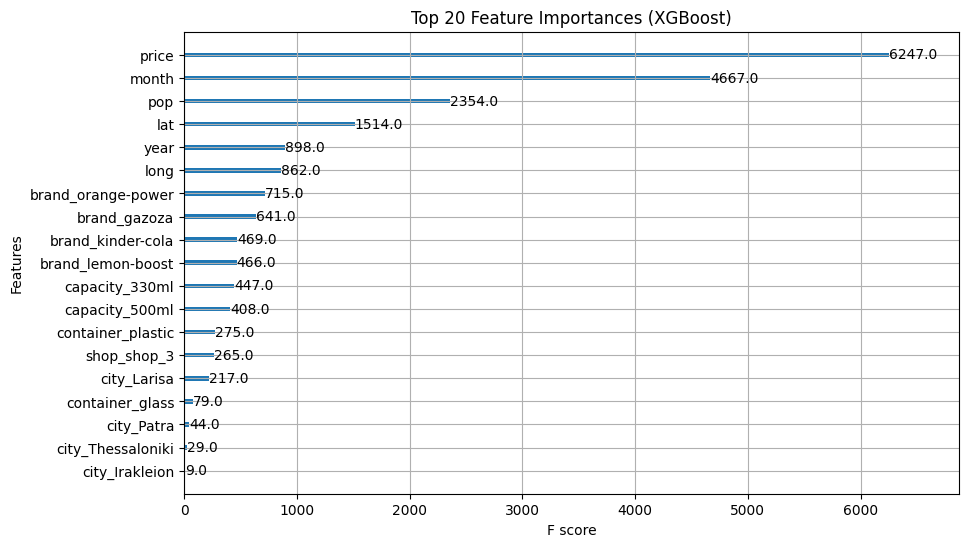

In [384]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
plot_importance(model, max_num_features=20, ax=ax)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

> #### Task:
- **Submit the predictions on the test dataset using your optimized model.** <br/>
    For each record in the test set (`Test.csv`), you must predict the value of the `quantity` variable. You should submit a CSV file with a header row and one row per test entry. 
The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **quantity**

In [385]:
# Predict on test set and save submission
test_ids = test['id']
test_pred = model.predict(X_test)
test_pred = np.maximum(test_pred, 0)  # Ensure non-negative predictions
submission_df = pd.DataFrame({"id": test_ids, "quantity": test_pred})

In [386]:
#Submission
submission_df.to_csv('submissions_final.csv',index=False)

In [387]:
print("Predictions saved to submission_xgb_short.csv")

Predictions saved to submission_xgb_short.csv


---